In [21]:
# %matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.spatial.transform import Rotation as R
from mpl_toolkits.mplot3d import Axes3D
from pytransform3d.rotations import matrix_from_quaternion
from pytransform3d.transformations import plot_transform

In [22]:
# Load data from the text file
# file_path = "rec1_rtabmap_slam.txt"
# file_path = "sawit/poses01.txt"
# file_path = "sawit/rtabmap_slam_03.txt"
# file_path = "rec_20250315/poses15_03_no-loop.txt"
# file_path = "Mamuang_21032025/rec01/poses2103-01.txt"
# file_path = "corridor_pares/poses01.txt"
# file_path = "corridor_STEI/poses01.txt"
file_path = "road_ITB_Pares/poses002.txt"

# Read data, skipping the first header row
data = np.loadtxt(file_path, skiprows=1)

# Extract positions and orientations
timestamps = data[:, 0]
positions = data[:, 1:4]  # x, y, z
quaternions = data[:, 4:8]  # qx, qy, qz, qw

In [23]:
print(positions)
print(quaternions)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.77236000e-01  1.16567000e-01 -2.10500000e-03]
 [ 3.16406000e-01  2.16666000e-01 -6.99950000e-02]
 ...
 [ 1.27052478e+03  5.91977783e+02  6.06197900e+00]
 [ 1.27052905e+03  5.91969055e+02  5.98455700e+00]
 [ 1.27050903e+03  5.91981689e+02  6.06097600e+00]]
[[ 0.017628 -0.126829  0.001121  0.991767]
 [ 0.005825 -0.082003 -0.022408  0.996363]
 [ 0.022691  0.006981 -0.038125  0.998991]
 ...
 [ 0.049399 -0.30349   0.304056  0.901667]
 [ 0.041307 -0.224832  0.280122  0.93235 ]
 [ 0.083244 -0.276301  0.331226  0.898342]]


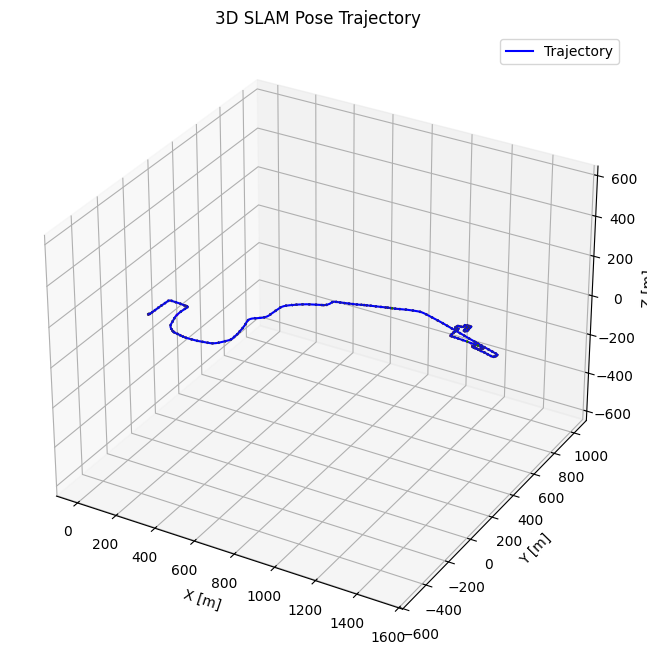

In [24]:
# Create 3D figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot trajectory
ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], 'b-', label="Trajectory")

# Plot coordinate frames at selected intervals
for i in range(0, len(positions), 5):  # Adjust step size for clarity
    position = positions[i]
    quaternion = quaternions[i]
    
    # Convert quaternion to rotation matrix
    rotation_matrix = matrix_from_quaternion(quaternion)
    
    # Create homogeneous transformation matrix
    transform = np.eye(4)
    transform[:3, :3] = rotation_matrix
    transform[:3, 3] = position  # Set translation

    # Plot frame
    plot_transform(ax=ax, A2B=transform, s=0.2)  # Scale of coordinate frame

# Labels and legend
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
ax.axis('equal')
ax.set_title("3D SLAM Pose Trajectory")
ax.legend()
plt.show()

In [25]:
# import numpy as np
# import plotly.graph_objects as go
# from scipy.spatial.transform import Rotation as R

# # Load data from the text file
# file_path = "rtabmap_slam.txt"

# # Read data, skipping the first header row
# data = np.loadtxt(file_path, skiprows=1)

# # Extract positions and quaternions
# positions = data[:, 1:4]  # x, y, z
# quaternions = data[:, 4:8]  # qx, qy, qz, qw

# Create a 3D scatter plot for the trajectory
fig = go.Figure(data=[go.Scatter3d(
    x=positions[:, 0],
    y=positions[:, 1],
    z=positions[:, 2],
    mode='lines',
    line=dict(color='blue', width=2),
    name='Trajectory',
    showlegend=False
)])

# Function to plot coordinate frames
def plot_coordinate_frame(fig, position, quaternion, scale=0.2):
    # Convert quaternion (qx, qy, qz, qw) to rotation matrix
    rotation = R.from_quat(quaternion).as_matrix()
    
    # Define origin
    origin = position
    
    # Define axes in local frame
    axes = np.eye(3) * scale
    
    # Transform axes to global frame
    transformed_axes = rotation @ axes
    
    # Define colors for x, y, z axes
    colors = ['red', 'green', 'blue']
    
    for i in range(3):
        fig.add_trace(go.Scatter3d(
            x=[origin[0], origin[0] + transformed_axes[0, i]],
            y=[origin[1], origin[1] + transformed_axes[1, i]],
            z=[origin[2], origin[2] + transformed_axes[2, i]],
            mode='lines',
            line=dict(color=colors[i], width=5),
            name=f'{colors[i]} axis',
            showlegend=False
        ))

# Plot coordinate frames at selected intervals
for i in range(0, len(positions), 5):  # Adjust step size for clarity
    plot_coordinate_frame(fig, positions[i], quaternions[i])

# Compute the range for each axis
x_range = positions[:, 0].max() - positions[:, 0].min()
y_range = positions[:, 1].max() - positions[:, 1].min()
z_range = positions[:, 2].max() - positions[:, 2].min()

# Determine the maximum range
max_range = max(x_range, y_range, z_range)

# Set the aspect ratio based on the maximum range
aspect_ratio = dict(x=x_range / max_range, y=y_range / max_range, z=z_range / max_range)

# Update layout to set equal aspect ratio
fig.update_layout(
    scene=dict(
        aspectmode='manual',
        aspectratio=aspect_ratio,
        xaxis=dict(title='X [m]'),
        yaxis=dict(title='Y [m]'),
        zaxis=dict(title='Z [m]')
    ),
    title='3D SLAM Pose Trajectory',
    legend=dict(x=0, y=1)
)

# Show the plot
fig.show()

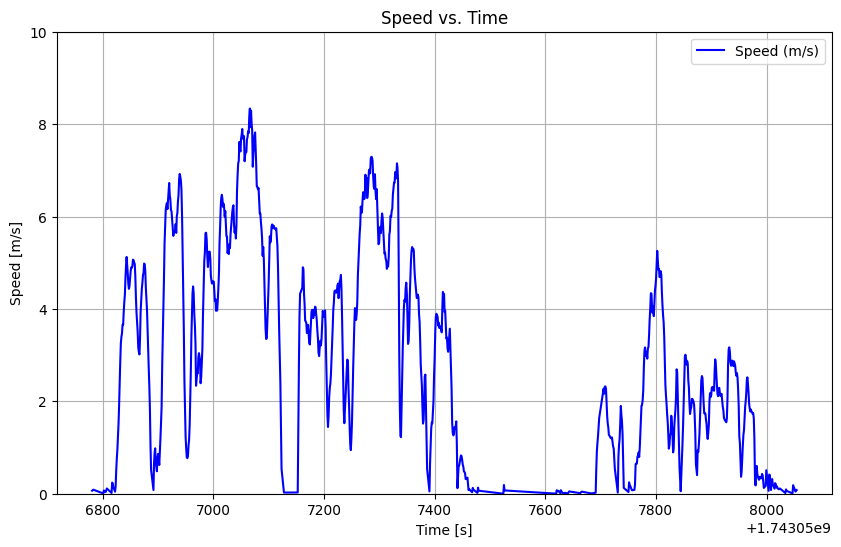

In [26]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Load data from the text file
# file_path = "rtabmap_slam.txt"

# # Read data, skipping the first header row
# data = np.loadtxt(file_path, skiprows=1)

# Extract timestamps and positions
# timestamps = data[:, 0]
# positions = data[:, 1:4]  # x, y, z

# Compute differences between consecutive timestamps and positions
delta_t = np.diff(timestamps)
delta_pos = np.diff(positions, axis=0)

# Calculate velocity components
velocities = delta_pos / delta_t[:, np.newaxis]

# Compute speed (norm of velocity)
speeds = np.linalg.norm(velocities, axis=1)

# Plot speed versus time
plt.figure(figsize=(10, 6))
plt.plot(timestamps[1:], speeds, label='Speed (m/s)', color='b')
plt.xlabel('Time [s]')
plt.ylabel('Speed [m/s]')
plt.title('Speed vs. Time')
plt.ylim(0, 10.0)  # Adjust limits for better visibility
# plt.axis('equal')
# plt.axis('tight')
plt.legend()
plt.grid(True)
plt.show()